We're trying to implement the pseudo-arclength continuation method described by Peeters et al. It has four steps: 

* a predictor step
* evaluation of the residual
* convergence check
* corrector step(s) (if not converged)

### Predictor step

The predictor step makes a first guess at the value of the next normal mode by assuming that the normal modes follow linear paths through parameter space:

$$\left( \begin{array}{c} \mathbf{z}_{p_0, (j+1)}\\ T_{(j+1)} \end{array}\right)  = 
\left( \begin{array}{c} \mathbf{z}_{p_0, (j)}\\ T_{(j)} \end{array}\right) + 
s_j\left( \begin{array}{c} \mathbf{p}_{\mathbf{z}_0, (j)}\\ p_{T,j} \end{array}\right)$$

The trick, then, is to calculate the tangent vector. We get there by solving the homogeneous system

$$\left[ \begin{array}{cc} {\partial \mathbf{H}\over\partial \mathbf{z}_{p_0}} & {\partial \mathbf{H}\over\partial T} \\
{\partial h \over \partial \mathbf{z}_{p_0}} & 0\end{array}\right] 
\left[\begin{array}{c}\mathbf{p}_{z,(j)}\\ p_{T,(j)} \end{array}\right] = 
\left[\begin{array}{c}\mathbf{0}\\0\end{array} \right]. $$

This amounts to finding the null space of the matrix, which we can do via singular value decomposition (SVD).

First we build the matrix. Essentially this is the same as the augmented jacobian we developed earlier; we'll just tweak our definitition to make it correct.

In [56]:
import matplotlib.pyplot as plt
import sympy
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.linalg import svd, pinv
from scipy.optimize import root

%matplotlib inline

In [3]:
# helper functions
def zdot(z, t):
    x1, x2, x1dot, x2dot = z
    x1ddot = -0.5*x1**3-(2*x1-x2)
    x2ddot = -(2*x2-x1)
    return (x1dot, x2dot, x1ddot, x2ddot)

def fire(z0, T, returnfull=False):
    t = np.linspace(0, T, 500)
    thetaseries = odeint(zdot, z0, t)
    if returnfull:
        return thetaseries
    else:
        return thetaseries[-1,:]

def measure(theta0, thetaT):
    """Calculate the residual"""
    return thetaT - theta0

def converged(residual, tol):
    """Check convergence to within tol, using the L2 norm"""
    if sum(residual**2) <= tol:
        return True
    else:
        return False, sum(residual**2)

def augjac(theta0, T):
    """Compute the augmented jacobian matrix.
    
    I'm choosing clarity over efficiency here; if it becomes necessary to change that, I'll refactor."""
    
    # get the baseline residual
    final = fire(theta0, T)
    H0 = measure(theta0, final)
    #print "augjac H0: ", H0
    # choose a step size for the FD that is 0.01% of the residual
    steps = np.abs(H0*0.0001)
    #print "augjac steps:", steps
    
    jac = []

    # finite differences
    for idx, step in enumerate(steps):
        thetaidx0 = np.array(theta0)
        thetaidx0[idx] += step
        Hidx = measure(thetaidx0, fire(thetaidx0, T))
        col = (Hidx-H0)/step
        if idx == 2:
            col = np.append(col,[1.0],0)
        else:
            col = np.append(col,[0.0],0)
        jac.append(col)

    # last column is a little different
    dHdT = zdot(final, T)
    jac.append(np.append(np.array(dHdT), 0.0))

    # turn it into a matrix and return the inverse
    return np.matrix(np.array(jac).T)

In [4]:
mat1 = augjac((0.001,0.001,0,0), 2*np.pi)
mat1

matrix([[ -5.51320455e-01,   5.51289422e-01,  -2.86854059e-01,
           2.86969721e-01,  -8.50753111e-08],
        [  5.55614785e-01,  -5.55645137e-01,   2.85252517e-01,
          -2.85136736e-01,  -8.53622136e-08],
        [  8.59745865e-01,  -8.59742191e-01,  -5.54055748e-01,
           5.53949139e-01,  -9.99871207e-04],
        [ -8.56574692e-01,   8.56577508e-01,   5.52878941e-01,
          -5.52985904e-01,  -9.99871259e-04],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
           0.00000000e+00,   0.00000000e+00]])

In [5]:
u,s,vh = svd(mat1)

In [6]:
tanvec = vh[-1]
tanvec[abs(tanvec)<1e-6] = 0
tanvec

array([ 0.70710474,  0.7071051 ,  0.        ,  0.        ,  0.00229382])

In [7]:
tanvec[0:4]

array([ 0.70710474,  0.7071051 ,  0.        ,  0.        ])

In [8]:
def tangentvector(z,T):
    mat = augjac(z,T)
    u,s,vh = svd(mat)
    tanvec = vh[-1]
    tanvec[abs(tanvec)<1.0e-6] = 0
    return tanvec

In [9]:
def predictor(z,T,step):
    tanvec = tangentvector(z,T)
    return z+step*tanvec[0:4], T + step*tanvec[-1]

The step size is apparently a little tricky. Peeters gives the relation $$s_{(j)} = \left({N^*\over N_{j-1}}\right) s_{(j-1)}, $$ where $N^*$ is the target number of iterations in the corrector, and $N_{(j-1)}$ is the number of iterations the last time around. I won't know how to set it up until I've played around with it a little bit.

### Residual Evaluation

Evaluating the residual is simple.

In [10]:
def residual(z,T):
    final = fire(z, T)
    return(measure(z, final))

### Convergence check

We've already defined a convergence check, but I'll duplicate it here.

In [11]:
def converged(residual, tol):
    """Check convergence to within tol, using the L2 norm"""
    if sum(residual**2) <= tol:
        return True
    else:
        return False, sum(residual**2)

### Corrector step(s)

For corrector steps, we use something like Newton-Raphson, but in practice I'll let `scipy.optimize.root` choose the exact method.

In [12]:
def objective(xvec):
    x1, x2, x1dot, x2dot, T = xvec
    res = fire((x1, x2, x1dot, x2dot), T, returnfull=False)
    return np.append(measure((x1, x2, x1dot, x2dot), res), x1dot)


def corrector(z,T):
    zt = np.append(z, T)
    iterres = root(objective, zt, jac=False)
    niter = iterres.nfev
    solution = iterres.x
    return solution

### Putting it all together

Because we're using a library routine to do the iterative correction, we don't even really need to run a convergence check before using it.

I'm going to package everything together into a class.

In [77]:
class Branch:
    def __init__(self):
        self.njminus1 = 10
        self.stepsize = 0.001
        self.nstar = 10
        self.tangenttol = 1.0e-6
        self.trajectory = []
        self.energies = []
        self.frequencies = []
        self.tanvecs = []
        self.niters = []
        self.stepsizes = []
        self.current_residual = 0.0
        self.converged_tol = 1.0e-8 
        
    # For the predictor step
    def zdot(self, z, t):
        """The derivative function.
        
        Depends on the model. This particular function is for 2DOF from Peeters."""
        
        x1, x2, x1dot, x2dot = z
        x1ddot = -0.5*x1**3-(2*x1-x2)
        x2ddot = -(2*x2-x1)
        return (x1dot, x2dot, x1ddot, x2ddot)

    def fire(self, z0, T, returnfull=False):
        """Wrapper for odeint."""
        t = np.linspace(0, T, 500)
        thetaseries = odeint(self.zdot, z0, t)
        if returnfull:
            return thetaseries
        else:
            return thetaseries[-1,:]

    def measure(self, theta0, thetaT):
        """Calculate the residual"""
        return thetaT - theta0
    
    def augjac(self, theta0, T):
        """Compute the augmented jacobian matrix.
    
        I'm choosing clarity over efficiency here; if it becomes necessary to change that, I'll refactor."""
    
        # get the baseline residual
        final = self.fire(theta0, T)
        H0 = self.measure(theta0, final)

        # choose a step size for the FD that is 0.01% of the residual
        steps = np.abs(H0*0.0001)
    
        jac = []

        # finite differences
        for idx, step in enumerate(steps):
            thetaidx0 = np.array(theta0)
            thetaidx0[idx] += step
            Hidx = self.measure(thetaidx0, fire(thetaidx0, T))
            col = (Hidx-H0)/step
            if idx == 2:
                col = np.append(col,[1.0],0)
            else:
                col = np.append(col,[0.0],0)
            jac.append(col)

        # last column is a little different
        dHdT = self.zdot(final, T)
        jac.append(np.append(np.array(dHdT), 0.0))
        
        # turn it into a matrix with the correct orientation
        return np.matrix(np.array(jac).T)        

    def tangentvector(self, z, T):
        mat = self.augjac(z,T)
        u,s,vh = svd(mat)
        tanvec = vh[-1]
        tanvec[abs(tanvec)<self.tangenttol] = 0
        return tanvec
        
    def predictor(self, z, T):
        tanvec = self.tangentvector(z,T)
        self.tanvecs.append(tanvec)
        self.stepsize = (self.stepsize*self.nstar)/self.njminus1
        self.stepsizes.append(self.stepsize)
        return z+self.stepsize*tanvec[0:4], T + self.stepsize*tanvec[-1]
    
    # corrector step
    def converged(self, z, T):
        final = self.fire(z, T)
        H = self.measure(z, final)
        if np.sqrt(sum(H**2))/np.sqrt(sum(z**2)) < self.converged_tol:
            return True
        else:
            return False
        
    def corrector(self, z, T):
        final = self.fire(z, T)
        H = self.measure(z, final)
        if np.sqrt(sum(H**2))/np.sqrt(sum(z**2)) < self.converged_tol:
            corrected = np.append(z, T)
        else:
            mat = self.augjac(z,T)
            # this will have been supplied by the predictor step
            tanvec = self.tanvecs[-1]
            cor_mat = np.matrix(np.reshape(np.append(np.array(mat), tanvec),(6,5)))
            invmat = pinv(cor_mat)
            rhs = np.append(-H, -final[2])
            correction = invmat * rhs.T
            corrected = np.append(z, T) + correction
        return corrected
    
    def nextpoint(self, z, T):
        #predictor
        predictedz, predictedT = self.predictor(z,T)
        
        #corrector if necessary
        corrected = self.corrector(predictedz, predictedT)
        
        # store results
        self.trajectory.append(corrected)
        self.energies.append(self.calc_energy(corrected))
        self.frequencies.append(self.calc_frequency(corrected))
        
        return corrected[0:4], corrected[-1]

    def calc_energy(self, zt):
        x1, x2, x1dot, x2dot, T = zt
        kinetic = (x1dot**2 + x2dot**2)/2.0
        potential = x1**2 + x2**2 - x1*x2 + x1**4/8.0
        return kinetic + potential
        
    def calc_frequency(self, zt):
        period = zt[-1]
        frequency = 1.0/period
        return frequency

In [78]:
inphase = Branch()

In [79]:
startz = np.array((0.0001, 0.0001, 0.0, 0.0))
startT = np.pi*2

predz, predT = predictor(startz,startT,0.001)

In [80]:
predz, predT

(array([  8.73929347e-05,   8.73935364e-05,   2.12184395e-09,
          4.09843864e-09]), 6.2821854661227388)

In [83]:
inphase.corrector(predz, predT)

ValueError: operands could not be broadcast together with shapes (5,6) (5,) 

In [82]:
inphase.nextpoint((4.45327585e-05, 4.45329371e-05, 0.0, 0.0), 6.28231930e+00)

ValueError: operands could not be broadcast together with shapes (5,6) (5,) 

In [76]:
inphase.trajectory

[array([[  6.39691709e-05,   5.96584234e-05,   3.59875729e-11,
           5.40518031e-08,   6.28332041e+00],
        [  5.81605961e-05,   5.21644488e-05,   3.53946611e-11,
          -4.28112352e-08,   6.28332130e+00],
        [  5.98228828e-05,   5.43073067e-05,  -3.33646855e-11,
           3.62447907e-08,   6.28332104e+00],
        [  5.97785423e-05,   5.42698178e-05,  -3.32855131e-11,
          -2.43688127e-08,   6.28332105e+00],
        [  7.92493268e-05,   7.92581322e-05,   6.20635141e-08,
           6.63367017e-08,   6.28331809e+00],
        [  7.92307905e-05,   7.92343337e-05,  -5.28112652e-15,
           5.72247348e-09,   6.28331816e+00]])]

In [20]:
inphase.stepsize

0.001

In [21]:
inphase.frequencies

[0.15915157960922488]

In [22]:
inphase.energies

[6.278357052806621e-09]

In [23]:
nextzt = inphase.nextpoint(np.array((4.46573393e-05,   4.46556388e-05,  -1.58600893e-26,-2.59958889e-09)),6.2823225677008958)

In [24]:
inphase.nstar = 20

In [25]:
nextz = nextzt[0]
nextT = nextzt[-1]
nextzt = inphase.nextpoint(nextz, nextT)

In [26]:
inphase.njminus1

51

In [27]:
inphase.stepsize

0.2

In [29]:
for x in range(10):
    nextz = nextzt[0]
    nextT = nextzt[-1]
    nextzt = inphase.nextpoint(nextz, nextT)

In [30]:
inphase.stepsizes

[0.001,
 0.01,
 0.2,
 0.0784313725490196,
 1.5686274509803921,
 31.372549019607842,
 627.4509803921568,
 12549.019607843136,
 250980.3921568627,
 5019607.843137254,
 100392156.86274508,
 2007843137.2549014,
 40156862745.09803]

In [31]:
inphase.niters

[1, 1, 51, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [32]:
inphase.tanvecs

[array([  3.47011162e-02,   3.47053563e-02,   0.00000000e+00,
          5.72243863e-06,   9.98794959e-01]),
 array([  3.50321398e-02,   3.50272874e-02,   0.00000000e+00,
         -7.41778429e-06,   9.98772165e-01]),
 array([ 0.04291904,  0.04291905,  0.        ,  0.        , -0.99815626]),
 array([ 0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  0.,  0., -1.]),
 array([ 0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  0.,  0., -1.]),
 array([ 0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  0.,  0., -1.])]

In [33]:
inphase.frequencies

[0.15915157960922488,
 0.15892413978564507,
 0.16412452784889267,
 0.16203868295994697,
 0.12919907765380881,
 0.025567246202497656,
 0.0015002321097295976,
 -8.4157685316784076e-05,
 4.1823865836292423e-06,
 -2.0918270633055738e-07,
 1.0458976828037966e-08,
 4.7540836508891082e-10,
 -2.6278855261211637e-11]

In [34]:
inphase.energies

[6.278357052806621e-09,
 1.5598837375716694e-07,
 2.9685681134563745e-47,
 2.9685681134563745e-47,
 2.9685681134563745e-47,
 2.9685681134563745e-47,
 2.9685681134563745e-47,
 2.9685681134563745e-47,
 2.9685681134563745e-47,
 2.9685681134563745e-47,
 2.9685681134563745e-47,
 2.9685681134563745e-47,
 2.9685681134563745e-47]

In [73]:
import matplotlib.pylab as plt
%matplotlib inline

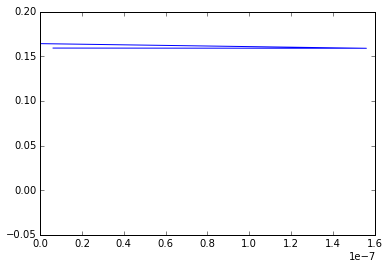

In [97]:
plt.plot(inphase.energies, inphase.frequencies)

In [75]:
nextzt

(array([  6.49836675e-05,   6.49775012e-05,   2.02792612e-32,
         -9.89535228e-09]), 6.2831871139649289)

In [98]:
inphase.energies

[6.2783570528076583e-09,
 1.5598837375717457e-07,
 6.0182044137832844e-20,
 6.0182044137832844e-20,
 6.0182044137832844e-20,
 6.0182044137832844e-20,
 6.0182044137832844e-20,
 6.0182044137832844e-20,
 6.0182044137832844e-20,
 6.0182044137832844e-20,
 6.0182044137832844e-20,
 6.0182044137832844e-20,
 6.0182044137832844e-20]

In [77]:
inphase.trajectory

[array([  7.92338747e-05,   7.92382934e-05,   0.00000000e+00,
          5.72243863e-09,   6.28331809e+00]),
 array([  7.96894791e-05,   7.96829262e-05,  -1.58600893e-26,
         -1.00173732e-08,   6.28332134e+00]),
 array([  4.50462805e-05,   4.50444898e-05,   2.02792612e-32,
         -3.00379645e-09,   6.28231760e+00]),
 array([  6.76958023e-05,   6.76908999e-05,   2.02792612e-32,
         -7.75694571e-09,   6.28295171e+00]),
 array([  6.87866171e-05,   6.87805498e-05,   2.02792612e-32,
         -9.70989542e-09,   6.28315327e+00]),
 array([  6.29085076e-05,   6.29023139e-05,   2.02792612e-32,
         -9.94506808e-09,   6.28321671e+00]),
 array([  6.40793120e-05,   6.40731336e-05,   2.02792612e-32,
         -9.92023704e-09,   6.28319647e+00]),
 array([  6.46982943e-05,   6.46921239e-05,   2.02792612e-32,
         -9.90359677e-09,   6.28319008e+00]),
 array([  6.48938152e-05,   6.48876476e-05,   2.02792612e-32,
         -9.89798466e-09,   6.28318805e+00]),
 array([  6.49557929e-05,   

In [37]:
inphase.frequencies

[0.15917679953927677,
 0.15917676526714192,
 0.15917679921790115,
 0.15917681578500067,
 0.15917681685407625,
 0.15917680885122801,
 0.15917683281633102,
 0.1591766728024957,
 0.15917663578287322,
 0.15917679575672614,
 0.159176689977405,
 0.15917667870991986,
 0.15917679457368988]

In [36]:
z = np.array([1.2, 1.3, 1.4, 1.5])
T = 6.2
np.append(z, T)

array([ 1.2,  1.3,  1.4,  1.5,  6.2])

In [37]:
inphase.trajectory[0]

array([  7.92338747e-05,   7.92382934e-05,   0.00000000e+00,
         5.72243863e-09,   6.28331809e+00])

In [41]:
z= inphase.trajectory[0][0:4]
T = inphase.trajectory[0][4]

In [58]:
mat = inphase.augjac(z, T)
tanvec = inphase.tangentvector(z, T)
auged = np.matrix(np.reshape(np.append(np.array(mat), tanvec),(6,5)) )
invmat = pinv(auged)
rhs = 

In [43]:
mat

matrix([[ -5.77191221e-01,   5.76827250e-01,  -3.07814407e-01,
           3.08587371e-01,  -6.20635909e-08],
        [  5.02793264e-01,  -5.03158025e-01,   2.67775610e-01,
          -2.67002697e-01,  -5.48915480e-08],
        [  8.17457519e-01,  -8.17852336e-01,  -5.64508104e-01,
           5.64183336e-01,  -7.92091117e-05],
        [ -9.08801079e-01,   9.08404433e-01,   5.15483356e-01,
          -5.15808755e-01,  -7.91981734e-05],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
           0.00000000e+00,   0.00000000e+00]])

In [45]:
tanvec

array([ 0.10916781,  0.10916764,  0.        ,  0.        , -0.98801053])